<!-- ### APPLICA DBSCAN -->

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

# Add these imports at the top
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import DBSCAN



In [28]:
df = pd.read_csv("pp_train.csv")

In [29]:
df = df[df["outlier_w_type"] != True]

### tutte log_trans -> per ora commentato

In [30]:


# features = df[['numVotes', 
#                 'totalCredits', 
#                 'criticReviewsTotal', 
#                'userReviewsTotal',
#                'fill_runtimeMinutes_Bruno', 
#                  ]]

#                 #'startYear', 'numRegions',
#                #'totalNominations', 
#                #'totalMedia',
#               #'countryOfOrigin_freq_enc'


# df_num = features.values

# #presuppongo di voler fare poi i controlli cluster in abse a titletype
# y = np.array(df['titleType']) 
# #a way to define x and y; they are the numpy arrays of the dataset

# y_map = {
#     0: 'tvEpisode',
#     1: 'videoGame',
#     2: 'movie',
#     3: 'tvSeries',
#     4: 'video',
#     5: 'tvMiniSeries',
#     6: 'short',
#     7: 'tvMovie',
#     8: 'tvSpecial',
#     9: 'tvShort'
# }
# y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)
# #y is our target label; mapped into strings (y_map)

<!-- ## Normalizzazioni -->

In [31]:
# X = df_num.copy()
# X = np.log1p(X)

# # # z-score, fit and then transform
# # scaler = StandardScaler()   #inizialize the standard scaler
# # scaler.fit(X) #fit the scaler on the data; x è la numpy matrix of the dataset
# # X_z_scal = scaler.transform(X) #transform to have the scaled version


# # min-max, fit and trasform directly
# scaler = MinMaxScaler()
# X_minmax = scaler.fit_transform(X) #fit e scaler in una riga sola

# #SCELTA NORMALIZZAZIONE
# #X_scal = X_z_scal
# X_scal = X_minmax  

### vecchie features

In [32]:
#dubbi
    # 'rating', 
    # 'countryOfOrigin_freq_enc', ->CASINO
    # ? -> 'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA','countryOfOrigin_UNK',

### log_ trans solo su alcune

In [33]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Selezione delle feature
features = df[['numVotes', 
               'totalCredits', 
               'criticReviewsTotal', 
               'userReviewsTotal',
               #'numRegions',
               #'totalMedia',
               #'startYear',
               'fill_runtimeMinutes_Bruno',
                #'totalNominationa'
                ]]

# Step 2: Applicazione della trasformazione logaritmica solo a 4 feature
features_log = features[['numVotes', 
                         'totalCredits', 
                         'criticReviewsTotal', 
                         #'numRegions',
                        # 'totalMedia'
                         'userReviewsTotal'
                         #'totalNominations'
                         ]].copy()
features_log = np.log1p(features_log)

# Step 3: Concatenazione con la colonna non trasformata
features_transformed = features_log.copy()
features_transformed['fill_runtimeMinutes_Bruno'] = features['fill_runtimeMinutes_Bruno']
#features_transformed['startYear'] = features['startYear']
# 
# Step 4: Normalizzazione Min-Max su tutte le colonne
scaler = MinMaxScaler()
X_scal = scaler.fit_transform(features_transformed)


### plot iniziale -> a cui aggiungere linee orizzontali che evidenzino area analizzata

In [34]:
dist = pdist(X_scal, 'euclidean') 
dist = squareform(dist)

    #risultato -> array compresso con distanze per ogni coppia di punti nel dataset.

import numpy as np
import matplotlib.pyplot as plt

ks = [5, 8, 10, 15, 20, 30, 50]
all_kth_distances = {}

# Calcola e salva le distanze k-esime ordinate per ogni k
for k in ks:
    kth_distances = []

    for d in dist:  # d è un array di distanze dalla riga i-esima agli altri punti
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    
    all_kth_distances[k] = sorted(kth_distances)

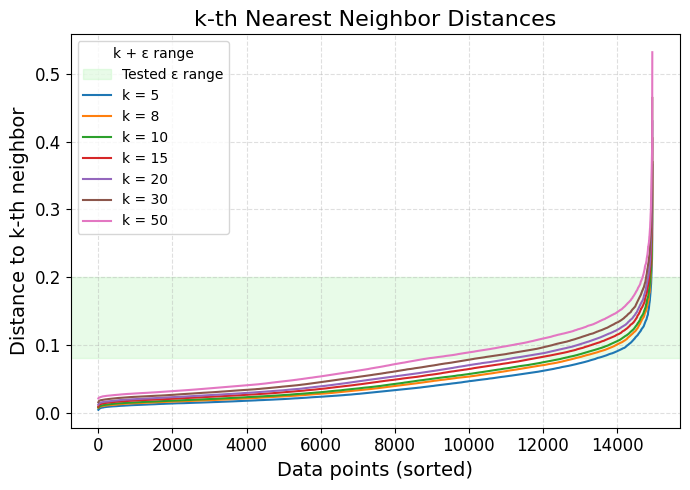

In [61]:


# # Plot
# plt.figure(figsize=(10, 6))
# for k in ks:
#     plt.plot(range(len(all_kth_distances[k])), all_kth_distances[k], label=f'k = {k}')

# plt.title('k-th Nearest Neighbor Distances')
# plt.xlabel('Data points (sorted)')
# plt.ylabel('Distance to k-th neighbor')
# plt.grid(True, alpha=0.3)
# plt.legend(title='k')
# plt.tight_layout()
# plt.show()


# Plot con fascia evidenziata tra y = 0.08 e y = 0.2
plt.figure(figsize=(7, 5))

# Aggiungi fascia evidenziata tra y = 0.08 e y = 0.2
plt.axhspan(0.08, 0.2, color='lightgreen', alpha=0.2, label='Tested ε range')

#linee
# plt.axhline(0.08, color='red', linestyle='--', linewidth=1, label='ε = 0.08')
# plt.axhline(0.2, color='green', linestyle='--', linewidth=1, label='ε = 0.2')


# Plot delle curve
for k in ks:
    plt.plot(range(len(all_kth_distances[k])), all_kth_distances[k], label=f'k = {k}')

plt.title('k-th Nearest Neighbor Distances', fontsize=16)
plt.xlabel('Data points (sorted)', fontsize=14)
plt.ylabel('Distance to k-th neighbor', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.4, linestyle='--')
plt.legend(title='k + ε range', loc='upper left')
plt.tight_layout()
plt.show()



# from kneed import KneeLocator

# for k in ks:
#     distances = all_kth_distances[k]
#     x = range(len(distances))
#     kl = KneeLocator(x, distances, curve='convex', direction='increasing')
#     print(f'k = {k} → Knee at index {kl.knee}, distance = {distances[kl.knee] if kl.knee else "N/A"}')


### valutazione parametri

In [36]:
# #CODICE LUNGO PER PROVARE VARIE COMBINAZIONI DI EPS E MIN_SAMPLES

# from sklearn.cluster import DBSCAN
# import numpy as np

# #Nooutliers, std scaler
# # eps_list = [1.6, 1.8, 2.0, 2.1,2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
# # min_samples_list = [4,5, 7, 8, 9, 10, 11, 15]

# #Nooutliers, minmax scaler
# eps_list =  [0.08,0.09, 0.1, 0.11, 0.12, 0.13, 0.14,0.16, 0.18, 0.2, 0.4, 1.0]
# min_samples_list = [4,5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20]

# for eps in eps_list:
#     for ms in min_samples_list:
#         db = DBSCAN(eps=eps, min_samples=ms).fit(X_scal)
#         labels, counts = np.unique(db.labels_, return_counts=True)
#         n_clusters = len(labels) - (1 if -1 in labels else 0)
#         n_noise = counts[labels == -1][0] if -1 in labels else 0

#         # lab = np.unique(db.labels_, return_counts=True)
#         # if n_clusters > 1:
#         # #silhouette_avg = silhouette_score(X_scal, db.labels_)
#         #     silhouette_avg = silhouette_score(X_scal[db.labels_ != -1], db.labels_[db.labels_ != -1])
#         #     print(f"eps={eps:.2f}, min_samples={ms} → Clusters: {n_clusters}, Noise: {n_noise}, Composition: {lab},Silhouette Score: {silhouette_avg:.4f} ")
        
#         if n_clusters > 1:
#             #silhouette_avg = silhouette_score(X_scal, db.labels_)
#             silhouette_avg = silhouette_score(X_scal[db.labels_ != -1], db.labels_[db.labels_ != -1])
#             if silhouette_avg > 0.1:
#                 lab = np.unique(db.labels_, return_counts=True)
#                 print(f"eps={eps:.2f}, min_samples={ms} → Clusters: {n_clusters}, Noise: {n_noise}, Silhouette Score: {silhouette_avg:.4f}, Composition: {lab} ")
        



### optimal eps grafico -> no

In [37]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial.distance import pdist, squareform
# from kneed import KneeLocator

# def calculate_k_distance_graph(X, k):
#     """
#     Calculate the k-distance graph for a pre-scaled dataset
    
#     Parameters:
#     -----------
#     X : numpy array
#         Pre-scaled input dataset
#     k : int
#         Number of nearest neighbors to consider
    
#     Returns:
#     --------
#     k_distances : numpy array
#         Sorted k-distances for each point
#     """
#     # Calculate pairwise distances
#     distances = pdist(X)
#     dist_matrix = squareform(distances)
    
#     # Sort distances for each point and get k-th distances
#     k_distances = np.sort(dist_matrix, axis=1)[:, k]
    
#     return k_distances

# def plot_k_distance_graph(X, k):
#     """
#     Plot the k-distance graph to help select epsilon for DBSCAN
#     using Kneedle algorithm
    
#     Parameters:
#     -----------
#     X : numpy array
#         Pre-scaled input dataset
#     k : int
#         Number of nearest neighbors to consider
    
#     Returns:
#     --------
#     optimal_epsilon : float
#         Suggested optimal epsilon value
#     """
#     # Calculate k-distances
#     k_distances = calculate_k_distance_graph(X, k)
    
#     # Sort k-distances in ascending order
#     sorted_k_distances = np.sort(k_distances)


    
#     # Use Kneedle algorithm to find the knee point
#     try:

#         kneedle = KneeLocator(
#             range(len(k_distances)), 
#             sorted_k_distances, 
#             curve="concave", 
#             direction="increasing"
#         )
        
#         # Get the optimal epsilon (knee point)
#         optimal_epsilon = sorted_k_distances[kneedle.knee] if kneedle.knee is not None else None
        
#         # Plot k-distance graph
#         plt.figure(figsize=(10, 6))
#         plt.plot(range(len(sorted_k_distances)), sorted_k_distances, 'b-')
#         plt.title(f'K-Distance Graph (k={k})')
#         plt.xlabel('Points')
#         plt.ylabel(f'{k}-Distance')
        
#         # Plot red line for optimal epsilon if found
#         if optimal_epsilon is not None:
#             plt.axhline(y=optimal_epsilon, color='r', linestyle='--', 
#                         label=f'Optimal ε ≈ {optimal_epsilon:.4f}')
#             plt.legend()
        
#         plt.axhline(y=0.12, color='g', linestyle='--', 
#                     label='Chosen ε = 0.12')
        
#         plt.legend()
#         plt.grid(True, linestyle='--', alpha=0.3)
#         plt.tight_layout()
#         plt.show()
        
#         return optimal_epsilon
    
#     except Exception as e:
#         print(f"Error finding optimal epsilon: {e}")
#         return None

# def main(X):
#     """
#     Main function to find optimal epsilon for DBSCAN
    
#     Parameters:
#     -----------
#     X : numpy array
#         Pre-scaled input dataset
#     """
#     # Plot k-distance graph and find optimal epsilon
#     optimal_epsilon = plot_k_distance_graph(X, k=15)
    
#     if optimal_epsilon is not None:
#         print(f"Suggested Optimal Epsilon: {optimal_epsilon:.4f}")
#     else:
#         print("Could not determine optimal epsilon")
    
#     return optimal_epsilon

# # Example usage
# if __name__ == '__main__':
#     X = X_scal
    
#     # Call main function with your pre-scaled data
#     main(X_scal)




# DBSCAN

In [38]:
dbscan = DBSCAN(eps=0.11, min_samples=7, metric="euclidean") 

dbscan.fit(X_scal)

DBSCAN(eps=0.11, min_samples=7)

In [39]:
dbscan.labels_ #get labels (classification of the diff clusters (-1 è il noise))
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2], dtype=int64),
 array([  219,  4347, 10378,    11], dtype=int64))

In [40]:
print('Silhouette', silhouette_score(X_scal, dbscan.labels_)) #con noise cluster

print('Silhouette', silhouette_score(X_scal[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]))  #senza noise

#         # misura silh su DBSCAN LABELS la conta anche rispetto al noise cluster (-1) 
#         # -> se non lo consid abbiamo valore + alto (i noise points sono lontani, lunghe distanze influenzano la silh) 
#             # -> quando la misuro scartiamo anche noise così misuriamo risultato solo sui cluster

Silhouette 0.2699427570764488
Silhouette 0.29260572700665965


### visualizzazioni combinazioni -> così no senso perchè non sono valori completi, quindi mettere una cosa con le linee non ha senso

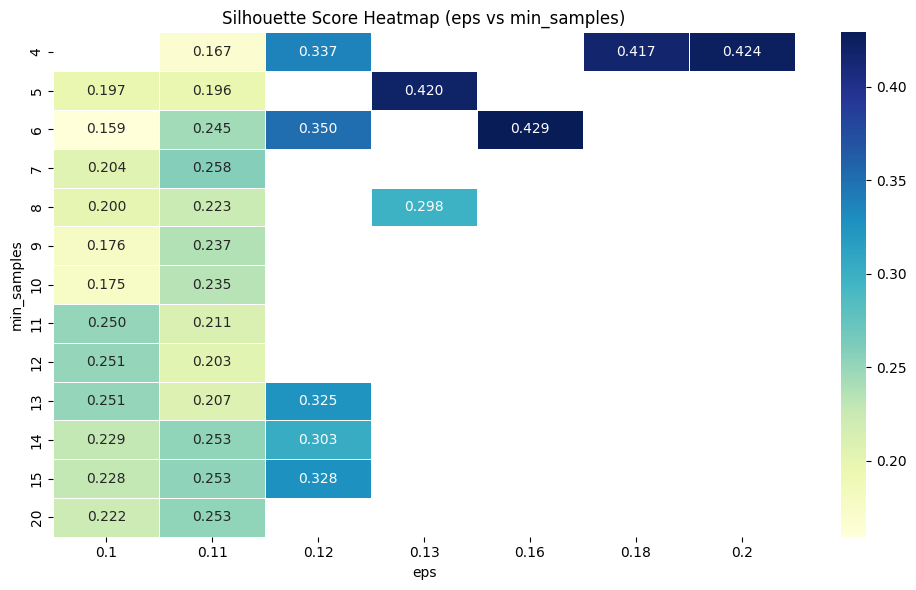

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Esempio: crea un DataFrame con i tuoi dati
data = {
    "eps": [
        0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10,
        0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
        0.12, 0.12, 0.12, 0.12, 0.12,
        0.13, 0.13,
        0.16,
        0.18,
        0.20
    ],
    "min_samples": [
        5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20,
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20,
        4, 6, 13, 14, 15,
        5, 8,
        6,
        4,
        4
    ],
    "clusters": [
        6, 5, 5, 4, 5, 4, 2, 2, 2, 3, 3, 3,
        6, 5, 3, 2, 4, 3, 3, 4, 4, 3, 2, 2, 2,
        3, 2, 3, 4, 3,
        2, 2,
        2,
        2,
        2
    ],
    "noise": [
        340, 383, 423, 465, 497, 543, 595, 624, 654, 679, 718, 918,
        184, 211, 244, 273, 302, 325, 351, 373, 415, 448, 481, 513, 601,
        137, 164, 282, 295, 305,
        102, 130,
        39,
        19,
        8
    ],
    "silhouette": [
        0.1973, 0.1594, 0.2045, 0.2003, 0.1765, 0.1752, 0.2503, 0.2507, 0.2510, 0.2286, 0.2284, 0.2220,
        0.1668, 0.1963, 0.2446, 0.2579, 0.2231, 0.2370, 0.2348, 0.2109, 0.2030, 0.2074, 0.2530, 0.2532, 0.2531,
        0.3371, 0.3505, 0.3250, 0.3029, 0.3275,
        0.4197, 0.2980,
        0.4290,
        0.4167,
        0.4245
    ]
}


df_res = pd.DataFrame(data)

# Pivot per creare la heatmap
heatmap_data = df_res.pivot(index='min_samples', columns='eps', values='silhouette')

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
plt.title("Silhouette Score Heatmap (eps vs min_samples)")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.tight_layout()
plt.show()


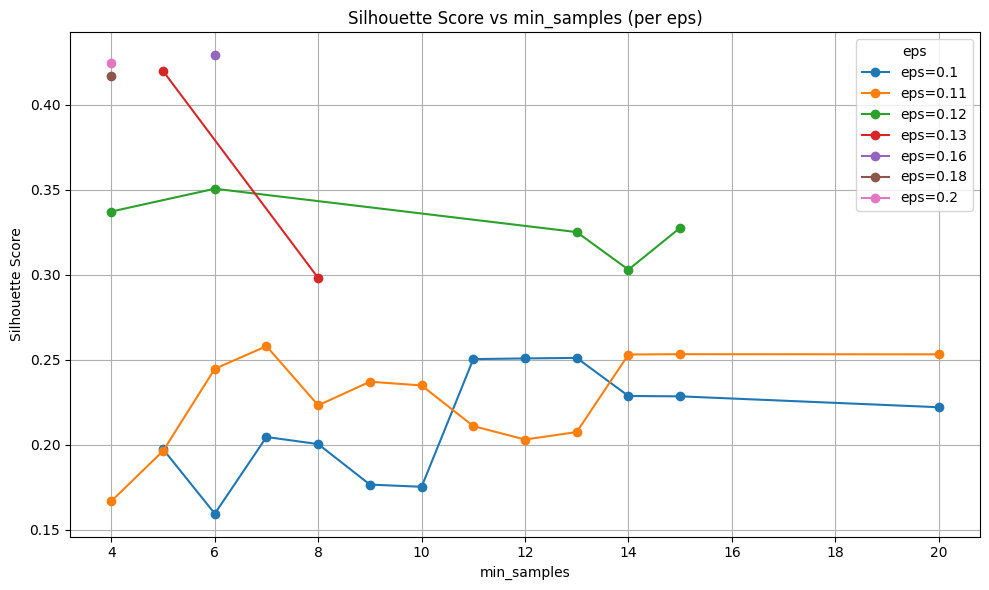

In [42]:
plt.figure(figsize=(10, 6))
for eps_value in sorted(df_res['eps'].unique()):
    subset = df_res[df_res['eps'] == eps_value]
    plt.plot(subset['min_samples'], subset['silhouette'], marker='o', label=f'eps={eps_value}')

plt.title("Silhouette Score vs min_samples (per eps)")
plt.xlabel("min_samples")
plt.ylabel("Silhouette Score")
plt.legend(title="eps")
plt.grid(True)
plt.tight_layout()
plt.show()


<!-- ### PCA PER VISUALIZZARLO -->

### VISUALIZZAZIONE CON PCA

PC1 spiega il 58.01% della varianza totale
PC2 spiega il 21.48% della varianza totale


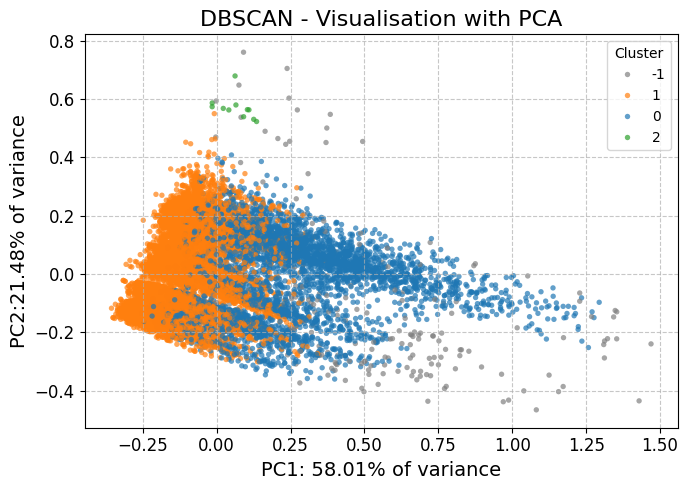

PC1 spiega il 58.01% della varianza totale
PC2 spiega il 21.48% della varianza totale

Statistiche dei Cluster:
--------------------------------------------------

Cluster -1:
Numero di punti: 219
Percentuale del dataset: 1.46%
Deviazione standard media delle features: 0.219
Range medio delle features: 0.996

Cluster 0:
Numero di punti: 4347
Percentuale del dataset: 29.07%
Deviazione standard media delle features: 0.141
Range medio delle features: 0.762

Cluster 1:
Numero di punti: 10378
Percentuale del dataset: 69.39%
Deviazione standard media delle features: 0.083
Range medio delle features: 0.536

Cluster 2:
Numero di punti: 11
Percentuale del dataset: 0.07%
Deviazione standard media delle features: 0.036
Range medio delle features: 0.118


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def plot_pca_dbscan(X_scal, labels, n_components=2):
    """
    Visualizza i risultati del clustering DBSCAN su una proiezione PCA (solo per visualizzazione).
    
    Parametri:
    - X_scal: dati già scalati (numpy array o DataFrame)
    - labels: etichette dei cluster ottenute da un DBSCAN già eseguito
    - n_components: numero di componenti principali per la PCA (default 2)
    """

    # PCA solo per visualizzazione
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scal)
    pca_columns = [f"PC{i+1}" for i in range(n_components)]
    pca_df = pd.DataFrame(X_pca, columns=pca_columns)

    # Aggiungi i cluster dal DBSCAN esterno
    pca_df['Cluster'] = labels.astype(str)

    # Palette colori
    # unique_clusters = np.unique(labels)
    # num_clusters = len(unique_clusters)
    # palette = sns.color_palette("tab10", num_clusters) if num_clusters > 1 else "tab10"
    # Color palette con grigio per il rumore (-1)
    unique_clusters = np.unique(labels)
    cluster_colors = {}

# Colori per i cluster veri (diversi da -1)
    colors = sns.color_palette("tab10", len(unique_clusters[unique_clusters != -1]))

    color_idx = 0
    for cluster in unique_clusters:
        if cluster == -1:
            cluster_colors[str(cluster)] = "gray"  # colore per il rumore
        else:
            cluster_colors[str(cluster)] = colors[color_idx]
            color_idx += 1



    var_exp = pca.explained_variance_ratio_
    var_percentages = []  # Nome diverso per evitare confusione

    for i, variance in enumerate(var_exp, start=1):
        percentage = variance * 100
        print(f"PC{i} spiega il {percentage:.2f}% della varianza totale")
        var_percentages.append(percentage)


    # Scatter plot
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=pca_df,
        x="PC1", y="PC2",
        hue="Cluster",
        #palette=palette,
        palette=cluster_colors,
        s=15, alpha=0.7, edgecolor='none'
    )


    plt.title("DBSCAN - Visualisation with PCA", fontsize=16)
    plt.xlabel(f"PC1: {var_percentages[0]:.2f}% of variance", fontsize=14)
    plt.ylabel(f"PC2:{var_percentages[1]:.2f}% of variance", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

   

    # Ottieni handles e labels attuali
    handles, labels = plt.gca().get_legend_handles_labels()

    # Crea una lista combinata e ordina mettendo "-1" al primo posto
    sorted_items = sorted(zip(labels, handles), key=lambda x: (x[0] != "-1", x[0] != "1", x[0]))

    # Separa di nuovo handles e labels
    sorted_labels, sorted_handles = zip(*sorted_items)

    # Imposta la legenda con l'ordine modificato
    plt.legend(sorted_handles, sorted_labels, title="Cluster", loc='best', frameon=True)
    plt.grid(True, alpha=0.7, linestyle='--')
    plt.tight_layout()
    plt.show()

    # Varianza spiegata per ogni PC (array di float)
    var_exp = pca.explained_variance_ratio_

    # Stampa in percentuale
    for i, var in enumerate(var_exp, start=1):
        print(f"PC{i} spiega il {var * 100:.2f}% della varianza totale")


plot_pca_dbscan(X_scal, dbscan.labels_)


# Statistiche per cluster
def cluster_statistics(X, labels):
    stats = {}
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        mask = labels == label
        cluster_points = X[mask]
        
        stats[f'Cluster {label}'] = {
            'Size': len(cluster_points),
            'Percentage': f"{(len(cluster_points) / len(X) * 100):.2f}%",
            'Mean': np.mean(cluster_points, axis=0),
            'Std': np.std(cluster_points, axis=0),
            'Min': np.min(cluster_points, axis=0),
            'Max': np.max(cluster_points, axis=0)
        }
    
    return stats

# # Calcola e mostra le statistiche
stats = cluster_statistics(X_scal, dbscan.labels_)
print("\nStatistiche dei Cluster:")
print("-" * 50)
for cluster, stat in stats.items():
    print(f"\n{cluster}:")
    print(f"Numero di punti: {stat['Size']}")
    print(f"Percentuale del dataset: {stat['Percentage']}")
    print(f"Deviazione standard media delle features: {np.mean(stat['Std']):.3f}")
    print(f"Range medio delle features: {np.mean(stat['Max'] - stat['Min']):.3f}")


### pairplot pca

In [44]:
# from sklearn.decomposition import PCA
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# def pairplot_pca_dbscan(X_scal, labels, n_components=3):
#     """
#     Crea un pair plot con le prime 3 componenti principali e cluster DBSCAN.
#     Include KDE sulle diagonali.
#     """
#     # PCA per riduzione dimensionale
#     pca = PCA(n_components=n_components)
#     X_pca = pca.fit_transform(X_scal)
#     pca_columns = [f"PC{i+1}" for i in range(n_components)]
#     pca_df = pd.DataFrame(X_pca, columns=pca_columns)

#     # Aggiunta etichette cluster
#     pca_df['Cluster'] = labels.astype(str)

#     # Palette personalizzata come nel tuo codice originale
#     unique_clusters = np.unique(labels)
#     cluster_colors = {}

#     # Colori per i cluster (escludendo il rumore -1)
#     colors = sns.color_palette("tab10", len(unique_clusters[unique_clusters != -1]))

#     color_idx = 0
#     for cluster in unique_clusters:
#         if cluster == -1:
#             cluster_colors[str(cluster)] = "lightgray"
#         else:
#             cluster_colors[str(cluster)] = colors[color_idx]
#             color_idx += 1

#     # Pairplot con le prime 3 PC
#     sns.pairplot(
#         pca_df,
#         vars=pca_columns,  # ['PC1', 'PC2', 'PC3']
#         hue="Cluster",
#         palette=cluster_colors,
#         diag_kind="kde",
#         plot_kws={'s': 20, 'alpha': 0.7, 'edgecolor': 'none'}
#     )

#     plt.suptitle("Pair Plot PCA (PC1, PC2, PC3) con Cluster DBSCAN", y=1.02)
#     plt.tight_layout()
#     plt.show()

# # Varianza spiegata per ogni PC (array di float)
#     var_exp = pca.explained_variance_ratio_

#     # Stampa in percentuale
#     for i, var in enumerate(var_exp, start=1):
#         print(f"PC{i} spiega il {var * 100:.2f}% della varianza totale")


        
# # Esempio di chiamata:
# pairplot_pca_dbscan(X_scal, dbscan.labels_, n_components=3)




In [45]:
# import numpy as np
# import pandas as pd
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# def determine_pca_components(df):
# #     # Select clustering variables ------------------------------------------------->   
# # # features = df[[''numVotes', 
#             #     'criticReviewsTotal', 
#             #    'userReviewsTotal',
#             #    'fill_runtimeMinutes_Bruno', 
#             #    'totalNominations', 
# # #                  ]]

# #     features = ["startYear", 
# #                     "numVotes", 
# #                     "totalCredits",
# #                     "numRegions", 
# #                     "userReviewsTotal",
# #                     # 'totalNominations', 
# #                     'totalMedia', 
# #                     "criticReviewsTotal"]
# #     X = df[features]
    
# #     # Apply log transformation to handle skewness
# #     X = np.log1p(X)
    
# #     # Scale data
# #     scaler = StandardScaler()
# #     X_scaled = scaler.fit_transform(X)
    
#     # Perform PCA
#     pca = PCA()
#     pca.fit(X_scal)
    
#     # Calculate cumulative explained variance ratio
#     cum_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    
#     # Determine optimal number of components
#     for i, ratio in enumerate(cum_var_ratio):
#         if ratio >= 0.8:
#             return i + 1
    
#     return len(cum_var_ratio)


# pp_train = pd.read_csv('pp_train.csv')
# optimal_components = determine_pca_components(pp_train)
# print(f"Optimal number of principal components: {optimal_components}")

In [46]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# optimal_components = 3

# def plot_pca_dbscan(df, features, n_components=optimal_components, eps=0.10, min_samples=20):
#     """
#     Apply PCA and DBSCAN clustering to the dataset and visualize the results.
    
#     :param df: DataFrame with the original data
#     :param features: List of features to use
#     :param n_components: Number of principal components for PCA
#     :param eps: DBSCAN epsilon parameter
#     :param min_samples: DBSCAN min_samples parameter
#     """
#     # # Preprocessing: Log-transform and scaling
#     # X = df[features].copy()
#     # X = np.log1p(X)  # Log-transform to stabilize variance
#     # scaler = StandardScaler()
#     # X_scaled = scaler.fit_transform(X)
    
#     # Apply PCA
#     pca = PCA(n_components=n_components)
#     X_pca = pca.fit_transform(X_scal)
    
#     # Create a DataFrame with principal components
#     pca_columns = [f"PC{i+1}" for i in range(n_components)]
#     pca_df = pd.DataFrame(X_pca, columns=pca_columns)
    
#     # Apply DBSCAN clustering
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     labels = dbscan.fit_predict(X_scal)
    
#     # Add cluster labels to the DataFrame
#     pca_df['Cluster'] = labels
    
#     # Convert noise points (-1) to a separate category for visualization
#     unique_clusters = np.unique(labels)
#     num_clusters = len(unique_clusters)
#     palette = sns.color_palette("tab10", num_clusters) if num_clusters > 1 else "tab10"
    
#     # Visualize with Seaborn pairplot


#     # sns.pairplot(
#     #     data=pca_df,
#     #     vars=["PC1", "PC2", "PC3", "PC4", "PC5"],
#     #     hue="Cluster",
#     #     diag_kind="kde",
#     #     palette="tab10"
#     # )

#     g =sns.pairplot(
#         data=pca_df,
#         vars=["PC1", "PC2", "PC3"],
#         hue="Cluster",
#         diag_kind="kde",
#         palette="tab10",
#         plot_kws={"s": 5, "alpha": 0.6, 'linewidth':0.1},
#     )

#      # Aggiungere stanghette agli assi per ogni subplot
#     for ax_row in g.axes:
#         for ax in ax_row:
#             if ax is not None:
#                 ax.tick_params(
#                     axis='both',  # Applica a entrambi gli assi
#                     direction='in',  # Stanghette verso l'interno
#                     length=4,  # Lunghezza delle stanghette
#                     width=1,  # Spessore delle stanghette
#                     which='both'  # Applica sia a major che a minor ticks
#                 )
                
                

#     plt.show()



#     plt.show()

# # Example usage:
# features = [
# 'numVotes', 
#                 #'startYear', 'numRegions',
#                 'totalCredits', 
#                 'criticReviewsTotal', 
#                'userReviewsTotal',
#                'fill_runtimeMinutes_Bruno', 
#                #'totalNominations', 
# ]

# # Assuming the DataFrame is called pp_train
# plot_pca_dbscan(X_scal, features,  n_components=optimal_components, eps=0.12, min_samples=8)

## pca vecchie

In [47]:
# import numpy as np
# import pandas as pd
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_pca_kmeans(df, features, n_components=5, n_clusters=4):
#     """
#     Applica PCA e K-Means ai dati preprocessati e visualizza i risultati.

#     :param df: DataFrame originale con i dati
#     :param features: Lista delle feature da utilizzare
#     :param n_components: Numero di componenti principali per la PCA
#     :param n_clusters: Numero di cluster per il K-Means
#     """
#     # Preprocessamento: Log-transform e scaling
#     X = df[features].copy()
#     X = np.log1p(X)  # Log-transform
#     scaler = MinMaxScaler()
#     # scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     # Applica PCA
#     pca = PCA(n_components=n_components)
#     X_pca = pca.fit_transform(X_scaled)

#     # Crea un DataFrame con le componenti principali
#     pca_columns = [f"PC{i+1}" for i in range(n_components)]
#     pca_df = pd.DataFrame(X_pca, columns=pca_columns)

#     # Applica K-Means sui dati preprocessati (X_scaled)
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     clusters = kmeans.fit_predict(X_scaled)

#     # Aggiungi i cluster come colonna al DataFrame delle componenti principali
#     pca_df['cluster'] = clusters

#     sns.pairplot(
#         data=pca_df,
#         vars=["PC1", "PC2", 'PC3'],
#         hue="cluster",
#         diag_kind="kde",
#         palette="tab10",
#         plot_kws={"s": 5, "alpha": 0.6, 'linewidth':0.1},
#     )

#     plt.show()

# features = [
#                     "startYear", 
#                     "numVotes", 
#                     "totalCredits",
#                     "numRegions", 
#                     "userReviewsTotal",
#                     # 'totalNominations', 
#                     'totalMedia', 
#                     "criticReviewsTotal"
# ]


# plot_pca_kmeans(pp_train, features, n_components=3, n_clusters=3) 


# # plt.savefig('C:\\Users\\Gagia\\Desktop\\progetto DM\\report_data_semantics\\plots\\pairplot_kmeans.png')


<!-- visualizzazione vecchia -> ma con al fondo i dati di info clusters e spiegazione variabilità -->

In [48]:
# import seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.cluster import DBSCAN
# import matplotlib.pyplot as plt
# import numpy as np

# # Create DBSCAN model with your chosen parameters
# dbscan = DBSCAN(eps=1.564, min_samples=11)  # Add your values here
# labels = dbscan.fit_predict(X_scal)

# # Apply PCA
# pca = PCA(n_components=5)
# X_pca = pca.fit_transform(X_scal)

# # Create a figure with a grid of subplots
# fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# # Add title with DBSCAN parameters
# plt.suptitle(f'DBSCAN Clustering (eps={dbscan.eps}, min_samples={dbscan.min_samples})', 
#              y=1.02, fontsize=12)

# # Create labels for each axis
# pc_labels = [f'PC{i+1}' for i in range(5)]

# # Plot each combination
# for i in range(5):
#     for j in range(5):
#         if i != j:
#             # Scatter plot
#             axes[i, j].scatter(X_pca[:, j], X_pca[:, i], 
#                              c=labels, cmap='Set2',
#                              alpha=0.5, s=20)
#             axes[i, j].set_xlabel(pc_labels[j])
#             axes[i, j].set_ylabel(pc_labels[i])
#         else:
#             # Density plot
#             for label in np.unique(labels):
#                 sns.kdeplot(data=X_pca[labels == label, i],
#                           ax=axes[i, i], fill=True,
#                           alpha=0.5)
#             axes[i, i].set_xlabel(pc_labels[i])
#             axes[i, i].set_ylabel('Density')

# # Add legend
# handles = [plt.scatter([], [], c=c, alpha=0.5, label=f'Cluster {l}')
#            for l, c in zip(np.unique(labels),
#                           plt.cm.Set2(np.linspace(0, 1, len(np.unique(labels)))))]
# fig.legend(handles=handles, title='Clusters', bbox_to_anchor=(1.02, 0.8))

# # Adjust layout
# plt.tight_layout()
# plt.show()

# # Print explained variance ratios
# print("\nExplained variance ratios:")
# for i, ratio in enumerate(pca.explained_variance_ratio_):
#     print(f"PC{i+1}: {ratio:.3f}")

# # Print clustering information
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise = list(labels).count(-1)
# print(f"\nNumber of clusters: {n_clusters}")
# print(f"Number of noise points: {n_noise}")

In [49]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.cluster import DBSCAN

# # Visualizzazione con PCA
# pca = PCA(n_components=optimal_components)
# X_pca = pca.fit_transform(X_scal)

# # Plot
# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan.labels_, cmap="tab10")
# plt.title('DBSCAN Clusters visualizzati con PCA')
# plt.xlabel(f'First PC (var: {pca.explained_variance_ratio_[0]:.3f})')
# plt.ylabel(f'Second PC (var: {pca.explained_variance_ratio_[1]:.3f})')

# # Statistiche per cluster
# def cluster_statistics(X, labels):
#     stats = {}
#     unique_labels = np.unique(labels)
    
#     for label in unique_labels:
#         mask = labels == label
#         cluster_points = X[mask]
        
#         stats[f'Cluster {label}'] = {
#             'Size': len(cluster_points),
#             'Percentage': f"{(len(cluster_points) / len(X) * 100):.2f}%",
#             'Mean': np.mean(cluster_points, axis=0),
#             'Std': np.std(cluster_points, axis=0),
#             'Min': np.min(cluster_points, axis=0),
#             'Max': np.max(cluster_points, axis=0)
#         }
    
#     return stats

# # Calcola e mostra le statistiche
# stats = cluster_statistics(X_scal, dbscan.labels_)

# print("\nStatistiche dei Cluster:")
# print("-" * 50)
# for cluster, stat in stats.items():
#     print(f"\n{cluster}:")
#     print(f"Numero di punti: {stat['Size']}")
#     print(f"Percentuale del dataset: {stat['Percentage']}")
#     print(f"Deviazione standard media delle features: {np.mean(stat['Std']):.3f}")
#     print(f"Range medio delle features: {np.mean(stat['Max'] - stat['Min']):.3f}")

<!-- ### codice per vedere sia plot che statistiche decsrittive dei cluster -->

In [50]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# optimal_components = 2

# def plot_pca_dbscan(df, features, n_components=optimal_components, eps=0.11, min_samples=20):
#     # # Preprocessing
#     # X = df[features].copy()
#     # X = np.log1p(X)
#     # scaler = StandardScaler()
#     # X_scal = scaler.fit_transform(X)

#     # PCA
#     pca = PCA(n_components=n_components)
#     X_pca = pca.fit_transform(X_scal)
#     pca_columns = [f"PC{i+1}" for i in range(n_components)]
#     pca_df = pd.DataFrame(X_pca, columns=pca_columns)

#     # Clustering
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     labels = dbscan.fit_predict(X_scal)
#     pca_df['Cluster'] = labels.astype(str)

#     # Color palette
#     unique_clusters = np.unique(labels)
#     num_clusters = len(unique_clusters)
#     palette = sns.color_palette("tab10", num_clusters) if num_clusters > 1 else "tab10"

#     # SCATTER PLOT PC1 vs PC2
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(
#         data=pca_df,
#         x="PC1", y="PC2",
#         hue="Cluster",
#         palette=palette,
#         s=15, alpha=0.7, edgecolor='none'
#     )

#     plt.title("PCA - PC1 vs PC2 with DBSCAN Clusters")
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.show()

# # Esempio di uso
# features = [
#     'numVotes',
#     'criticReviewsTotal',
#     'userReviewsTotal',
#     'fill_runtimeMinutes_Bruno',
#     #'totalNominations',
#     'totalCredits'
# ]

# # Assicurati di passare un DataFrame reale qui
# # plot_pca_dbscan(pp_train, features)


# plot_pca_dbscan(X_scal, features)


# # Calcola e mostra le statistiche
# stats = cluster_statistics(X_scal, dbscan.labels_)

# print("\nStatistiche dei Cluster:")
# print("-" * 50)
# for cluster, stat in stats.items():
#     print(f"\n{cluster}:")
#     print(f"Numero di punti: {stat['Size']}")
#     print(f"Percentuale del dataset: {stat['Percentage']}")
#     print(f"Deviazione standard media delle features: {np.mean(stat['Std']):.3f}")
#     print(f"Range medio delle features: {np.mean(stat['Max'] - stat['Min']):.3f}")
